Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure, v_measure_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [2]:
X, y = load_digits(return_X_y=True)

In [3]:
# проверка размерности 
X.shape, y.shape

((1797, 64), (1797,))

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [4]:
X = abs(X-16) #инверсия цвета

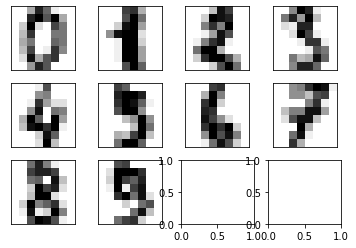

In [5]:
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, X[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(8,8), interpolation=None)
plt.show()

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [6]:
clustering_agg = AgglomerativeClustering(n_clusters=10)
clustering_k = KMeans(n_clusters=10, n_init=100)

In [7]:
clusters_agg = clustering_agg.fit_predict(X)
clusters_k = clustering_k.fit_predict(X)

In [8]:
clusters_agg.shape, clusters_k.shape

((1797,), (1797,))

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [9]:
X_mean_agg = np.array([np.sum(X[np.where(clusters_agg==x)], axis=0)/
                       len(X[np.where(clusters_agg==x)]) for x in clustering_agg.labels_])
X_mean_k = np.array([np.sum(X[np.where(clusters_k==x)], axis=0)/
                     len(X[np.where(clusters_k==x)]) for x in clustering_k.labels_])

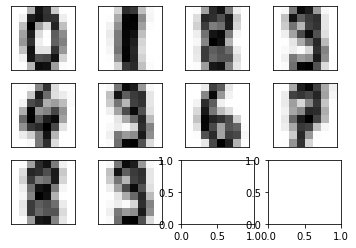

In [10]:
#Визуализация центров кластеров, полученных методом иерархической кластеризации
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, X_mean_agg[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(8,8))
plt.show()

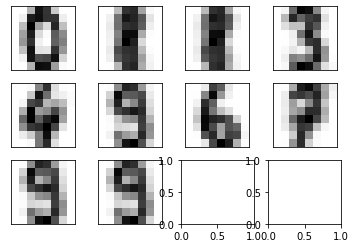

In [11]:
#Визуализация центров кластеров, полученных методом 𝐾 средних
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, X_mean_k[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(8,8))
plt.show()

*На моем примере получилось, что центры кластеров, полученные методом иерархической кластеризации выглядят более чёткими и похожими на цифры. При иерархическом методе цифра 8 получилась более четкой.*

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [12]:
silhouette_agg = []
silhouette_k = []
print('                            Кол-во признаков | "Silhouette score"')
print('-'*70)
for i in range(2,21):
    clustering_k = KMeans(n_clusters=i, n_init=10)
    clustering_k.fit(X)
    clustering_agg = AgglomerativeClustering(n_clusters=i)
    clustering_agg.fit(X)
    silhouette_agg.append(silhouette_score(X, clustering_agg.labels_))
    silhouette_k.append(silhouette_score(X, clustering_k.labels_))
    #print('При K = {} "silhouette" для иерархической кластеризации = {:.4f}, для K средних = {:.4f}'.
    #      format(i, silhouette_score(X, clustering_agg.labels_), silhouette_score(X, clustering_k.labels_)))
    print("""Иерархическая кластеризация {:^17}| {:^17.4f}""".
          format(i, silhouette_score(X, clustering_agg.labels_), silhouette_score(X, clustering_k.labels_)))
    print("""Метод К-средних             {:^17}| {:^17.4f}""".
         format(i, silhouette_score(X, clustering_agg.labels_), silhouette_score(X, clustering_agg.labels_)))
    print('-'*70)

                            Кол-во признаков | "Silhouette score"
----------------------------------------------------------------------
Иерархическая кластеризация         2        |      0.1167      
Метод К-средних                     2        |      0.1167      
----------------------------------------------------------------------
Иерархическая кластеризация         3        |      0.1119      
Метод К-средних                     3        |      0.1119      
----------------------------------------------------------------------
Иерархическая кластеризация         4        |      0.1090      
Метод К-средних                     4        |      0.1090      
----------------------------------------------------------------------
Иерархическая кластеризация         5        |      0.1189      
Метод К-средних                     5        |      0.1189      
----------------------------------------------------------------------
Иерархическая кластеризация         6        |      0.1370 

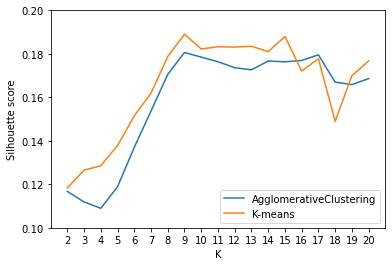

In [13]:
plt.axis([1,21,0.10,0.20])
plt.xticks(np.arange(2,21,1))
plt.plot(np.arange(2,21,1), silhouette_agg)
plt.plot(np.arange(2,21,1), silhouette_k)
plt.ylabel('Silhouette score')
plt.xlabel('K')
plt.legend(['AgglomerativeClustering', 'K-means'])
plt.show()

In [14]:
print("""При К={} достигается максимум "silhouette_score" для метода иерархической кластеризации равное {:.4f}"""
      .format([x for x in range(2,21)][silhouette_agg.index(max(silhouette_agg))], max(silhouette_agg)))
print("""При К={} достигается максимум "silhouette_score" для метода К-средних равное {:.4f}"""
      .format([x for x in range(2,21)][silhouette_k.index(max(silhouette_k))], max(silhouette_k)))

При К=9 достигается максимум "silhouette_score" для метода иерархической кластеризации равное 0.1806
При К=9 достигается максимум "silhouette_score" для метода К-средних равное 0.1890


Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [15]:
v_measure_agg = []
v_measure_k = []
print('                            Кол-во признаков |      V-мера')
print('-'*70)
for i in range(2,21):
    clustering_k = KMeans(n_clusters=i, n_init=10)
    clustering_k.fit(X)
    clustering_agg = AgglomerativeClustering(n_clusters=i)
    clustering_agg.fit(X)
    v_measure_agg.append(v_measure_score(y, clustering_agg.labels_))
    v_measure_k.append(v_measure_score(y, clustering_k.labels_))
    #print("""При K = {} 𝑉-мера для иерархической кластеризации = {:.4f}, для K-средних = {:.4f}"""
    #      .format(i, v_measure_score(y, clustering_agg.labels_), v_measure_score(y, clustering_k.labels_)))
    print("""Иерархическая кластеризация {:^17}| {:^17.4f}""".format(i, v_measure_score(y, clustering_agg.labels_)))
    print("""Метод К-средних             {:^17}| {:^17.4f}""".format(i, v_measure_score(y, clustering_k.labels_)))
    print('-'*70)

                            Кол-во признаков |      V-мера
----------------------------------------------------------------------
Иерархическая кластеризация         2        |      0.4082      
Метод К-средних                     2        |      0.3600      
----------------------------------------------------------------------
Иерархическая кластеризация         3        |      0.5441      
Метод К-средних                     3        |      0.4040      
----------------------------------------------------------------------
Иерархическая кластеризация         4        |      0.6212      
Метод К-средних                     4        |      0.4535      
----------------------------------------------------------------------
Иерархическая кластеризация         5        |      0.7097      
Метод К-средних                     5        |      0.5830      
----------------------------------------------------------------------
Иерархическая кластеризация         6        |      0.7567      
М

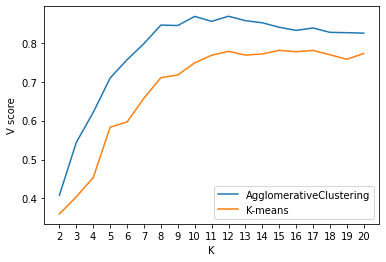

In [16]:
plt.xticks(np.arange(2,21,1))
plt.plot(np.arange(2,21,1), v_measure_agg)
plt.plot(np.arange(2,21,1), v_measure_k)
plt.ylabel('V score')
plt.xlabel('K')
plt.legend(['AgglomerativeClustering', 'K-means'])
plt.show()

In [17]:
print("""При К={} достигается максимум 𝑉-меры для метода иерархической кластеризации равное {:.4f}"""
      .format([x for x in range(2,21)][v_measure_agg.index(max(v_measure_agg))], max(v_measure_agg)))
print("""При К={} достигается максимум 𝑉-меры для метода К-средних равное {:.4f}"""
      .format([x for x in range(2,21)][v_measure_k.index(max(v_measure_k))], max(v_measure_k)))

При К=12 достигается максимум 𝑉-меры для метода иерархической кластеризации равное 0.8685
При К=15 достигается максимум 𝑉-меры для метода К-средних равное 0.7808


# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [18]:
svd_silhouette_agg = []
svd_silhouette_k = []
print('                            Кол-во признаков | "Silhouette score"')
print('-'*70)
for i in [2, 5, 10, 20]:
    svd = TruncatedSVD(n_components=i, random_state=0).fit_transform(X)
    clustering_agg.n_clusters = 10
    clustering_k.n_clusters = 10
    clusters_svd_agg = clustering_agg.fit(svd)
    clusters_svd_k = clustering_k.fit(svd)
    svd_silhouette_agg.append(silhouette_score(svd, clusters_svd_agg.labels_)) 
    svd_silhouette_k.append(silhouette_score(svd, clusters_svd_k.labels_))
    print("""Иерархическая кластеризация {:^17}| {:^17.4f}""".
          format(i, silhouette_score(svd, clusters_svd_agg.labels_)))
    print("""Метод К-средних             {:^17}| {:^17.4f}""".
         format(i, silhouette_score(svd, clusters_svd_k.labels_)))
    print('-'*70)
    

                            Кол-во признаков | "Silhouette score"
----------------------------------------------------------------------
Иерархическая кластеризация         2        |      0.3134      
Метод К-средних                     2        |      0.3561      
----------------------------------------------------------------------
Иерархическая кластеризация         5        |      0.2658      
Метод К-средних                     5        |      0.3283      
----------------------------------------------------------------------
Иерархическая кластеризация        10        |      0.2476      
Метод К-средних                    10        |      0.2745      
----------------------------------------------------------------------
Иерархическая кластеризация        20        |      0.2088      
Метод К-средних                    20        |      0.2146      
----------------------------------------------------------------------


In [19]:
print("""При кол-ве признаков={} достигается максимум "silhouette_score" для метода иерархической кластеризации равное {:.4f}"""
      .format([2, 5, 10, 20][svd_silhouette_agg.index(max(svd_silhouette_agg))], max(svd_silhouette_agg)))

print("""При кол-ве признаков={} достигается максимум "silhouette_score" для метода К-средних равное {:.4f}"""
      .format([2, 5, 10, 20][svd_silhouette_k.index(max(svd_silhouette_k))], max(svd_silhouette_k)))

При кол-ве признаков=2 достигается максимум "silhouette_score" для метода иерархической кластеризации равное 0.3134
При кол-ве признаков=2 достигается максимум "silhouette_score" для метода К-средних равное 0.3561


In [20]:
print("""При кол-ве признаков={} "silhouette_score" для метода иерархической кластеризации равен {:.4f}"""
      .format(64, silhouette_agg[8]))
print("""При кол-ве признаков={} "silhouette_score" для метода К-средних равен {:.4f}"""
      .format(64, silhouette_k[8]))

При кол-ве признаков=64 "silhouette_score" для метода иерархической кластеризации равен 0.1785
При кол-ве признаков=64 "silhouette_score" для метода К-средних равен 0.1822


In [21]:
svd_v_measure_agg = []
svd_v_measure_k = []
print('                            Кол-во признаков |      V-мера')
print('-'*70)
for i in [2, 5, 10, 20]:
    svd = TruncatedSVD(n_components=i, random_state=0).fit_transform(X)
    clustering_agg.n_clusters = 10
    clustering_k.n_clusters = 10
    clusters_svd_agg = clustering_agg.fit(svd)
    clusters_svd_k = clustering_k.fit(svd)
    svd_v_measure_agg.append(v_measure_score(y, clusters_svd_agg.labels_))
    svd_v_measure_k.append(v_measure_score(y, clusters_svd_k.labels_))
    print("""Иерархическая кластеризация {:^17}| {:^17.4f}""".format(i, v_measure_score(y, clusters_svd_agg.labels_)))
    print("""Метод К-средних             {:^17}| {:^17.4f}""".format(i, v_measure_score(y, clusters_svd_k.labels_)))
    print('-'*70)

                            Кол-во признаков |      V-мера
----------------------------------------------------------------------
Иерархическая кластеризация         2        |      0.3526      
Метод К-средних                     2        |      0.3527      
----------------------------------------------------------------------
Иерархическая кластеризация         5        |      0.6416      
Метод К-средних                     5        |      0.6357      
----------------------------------------------------------------------
Иерархическая кластеризация        10        |      0.8198      
Метод К-средних                    10        |      0.7307      
----------------------------------------------------------------------
Иерархическая кластеризация        20        |      0.8731      
Метод К-средних                    20        |      0.7383      
----------------------------------------------------------------------


In [22]:
print("""При кол-ве признаков={} достигается максимум V-меры для метода иерархической кластеризации равный {:.4f}"""
      .format([2, 5, 10, 20][svd_v_measure_agg.index(max(svd_v_measure_agg))], max(svd_v_measure_agg)))

print("""При кол-ве признаков={} достигается максимум V-меры для метода К-средних равный {:.4f}"""
      .format([2, 5, 10, 20][svd_v_measure_k.index(max(svd_v_measure_k))], max(svd_v_measure_k)))

При кол-ве признаков=20 достигается максимум V-меры для метода иерархической кластеризации равный 0.8731
При кол-ве признаков=20 достигается максимум V-меры для метода К-средних равный 0.7383


In [23]:
print("""При кол-ве признаков={} 𝑉-мера для метода иерархической кластеризации равна {:.4f}"""
      .format(64, v_measure_agg[8]))
print("""При кол-ве признаков={} 𝑉-мера для метода К-средних равна {:.4f}"""
      .format(64, v_measure_k[8]))

При кол-ве признаков=64 𝑉-мера для метода иерархической кластеризации равна 0.8682
При кол-ве признаков=64 𝑉-мера для метода К-средних равна 0.7486


*При* **𝑑′**= 2 *удалось получить лучшее значение силуэта, чем на исходных данных, причем на обоих методах (иерархическая кластеризация, метод К-средних).*

*При* **𝑑′**= 20 *значение V-меры при иерархической кластеризации получено лучше, чем на исходных данных. При методе К-средних наблюдается небольшое снижение данного показателя в сравнении с исходными данными.*

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [24]:
t_sne = TSNE(n_components=2, init='pca', random_state=0)
t_embed = t_sne.fit_transform(X)

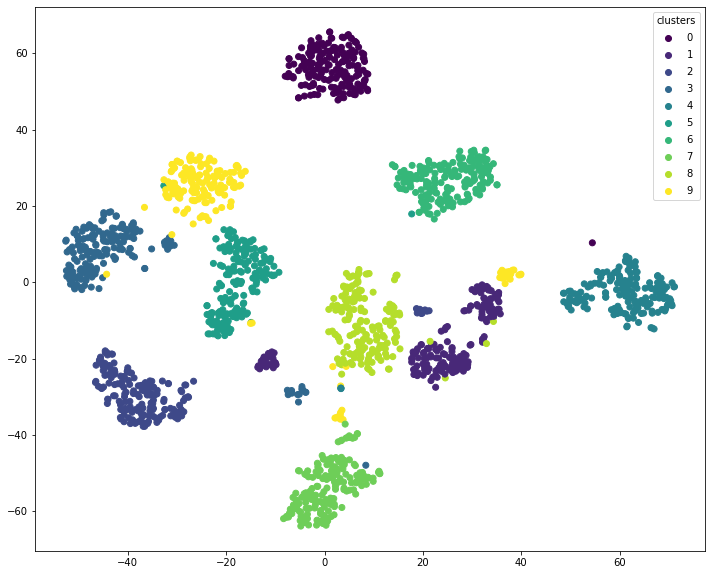

In [25]:
fig, ax = plt.subplots(figsize=(12,10))
cltrs = ax.scatter(x=t_embed[:, 0], y=t_embed[:, 1], c=y, cmap='viridis')
ax.legend(*cltrs.legend_elements(), title='clusters')
plt.show()

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [26]:
print('                            Кол-во признаков |"Silhouette_score"')
print('-'*70)
clustering_agg.n_clusters = 10
clustering_k.n_clusters = 10
clusters_sne_agg = clustering_agg.fit(t_embed)
clusters_sne_k = clustering_k.fit(t_embed)
print("""Иерархическая кластеризация {:^17}| {:^17.4f}""".format(2, silhouette_score(t_embed, clusters_sne_agg.labels_)))
print("""Метод К-средних             {:^17}| {:^17.4f}""".format(2, silhouette_score(t_embed, clusters_sne_k.labels_)))
print('-'*70)

                            Кол-во признаков |"Silhouette_score"
----------------------------------------------------------------------
Иерархическая кластеризация         2        |      0.6161      
Метод К-средних                     2        |      0.6268      
----------------------------------------------------------------------


In [27]:
print("""При кол-ве признаков={} "silhouette_score" для метода иерархической кластеризации равен {:.4f}"""
      .format(64, silhouette_agg[8]))
print("""При кол-ве признаков={} "silhouette_score" для метода К-средних равен {:.4f}"""
      .format(64, silhouette_k[8]))

При кол-ве признаков=64 "silhouette_score" для метода иерархической кластеризации равен 0.1785
При кол-ве признаков=64 "silhouette_score" для метода К-средних равен 0.1822


In [28]:
print('                            Кол-во признаков |      V-мера')
print('-'*70)
clustering_agg.n_clusters = 10
clustering_k.n_clusters = 10
clusters_sne_agg = clustering_agg.fit(t_embed)
clusters_sne_k = clustering_k.fit(t_embed)
print("""Иерархическая кластеризация {:^17}| {:^17.4f}""".format(2, v_measure_score(y, clusters_sne_agg.labels_)))
print("""Метод К-средних             {:^17}| {:^17.4f}""".format(2, v_measure_score(y, clusters_sne_k.labels_)))
print('-'*70)

                            Кол-во признаков |      V-мера
----------------------------------------------------------------------
Иерархическая кластеризация         2        |      0.9073      
Метод К-средних                     2        |      0.9107      
----------------------------------------------------------------------


In [29]:
print("""При кол-ве признаков={} 𝑉-мера для метода иерархической кластеризации равна {:.4f}"""
      .format(64, v_measure_agg[8]))
print("""При кол-ве признаков={} 𝑉-мера для метода К-средних равна {:.4f}"""
      .format(64, v_measure_k[8]))

При кол-ве признаков=64 𝑉-мера для метода иерархической кластеризации равна 0.8682
При кол-ве признаков=64 𝑉-мера для метода К-средних равна 0.7486


*Значение силуэта получено выше после снижения размерности при обоих методах кластеризации. Значение V-меры как при иерархической кластеризации, так и методе К-средних получено выше, чем на исходных данных, а также выше, чем при сингулярном разложении матрицы.*

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [30]:
# возьмем центры кластеров после снижения размерности алгоритмом tSNE
clustering_agg.n_clusters = 10
clustering_k.n_clusters = 10
sne_agg_labels = clustering_agg.fit_predict(t_embed)
sne_k_labels = clustering_k.fit_predict(t_embed)

In [31]:
X_sne_agg = np.array([np.sum(X[np.where(sne_agg_labels==x)], axis=0)/
                      len(X[np.where(sne_agg_labels==x)]) for x in sne_agg_labels])
X_sne_k = np.array([np.sum(X[np.where(sne_k_labels==x)], axis=0)/
                    len(X[np.where(sne_k_labels==x)]) for x in sne_k_labels])

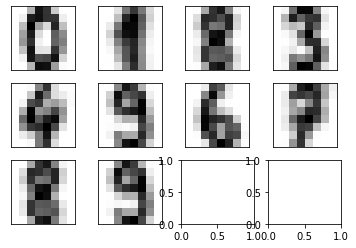

In [32]:
#Визуализация центров кластеров, полученных методом иерархической кластеризации, после снижения размерности 
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, X_sne_agg[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(8,8))
plt.show()

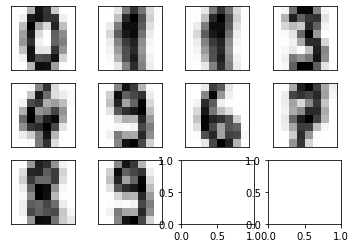

In [33]:
#Визуализация центров кластеров, полученных методом К-средних, после снижения размерности
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, X_sne_k[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(8,8))
plt.show()

*Соответствия кластера одной цифре добиться не удалось.*

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

*После проделанной работы, могу отметить, что по моим наблюдениям на данном датасете, лучшие результаты показало иерархическая кластеризация, хотя по таким метрикам как силуэт и V-мера в некоторых случаях метод К-средних работал качественнее.
Но на визуализации цифр видно, что метод иерархической кластеризации лучше разделил кластеры, и цифры на изображениях получились более осмысленными.*


*Качество кластеризации при снижении размерности улучшилось, это видно и на графических изображениях цифр. После снижения размерности количество уникальных цифр возросло. Например, цифры 1 и 3 стали более четкими и лучше распознаваемыми. В двух случаях мы наблюдали увеличеение количества уникальных цифр на графике, но все же каждый кластер не всегда соответствовал одной цифре.*

*Подводя итоги можно сделать вывод, что качество кластеризации при применении различных алгоритмов (Иерархическая, метод К-средних, DBSCAN и др.) будет зависесть от размера и формы признакового пространства. Возможно придется применить несколько методик, прежде, чем получится качественный результат. В любом случае, при снижении размерности признакового пространства качество кластеризации можно улучшить, а также отображить графически, чтобы лучше понимать задачу.*


**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [84]:
from sklearn.datasets import fetch_openml

In [85]:
#загрузим датасет MNIST
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

In [86]:
#инверсия цвета
X_mnist = np.array(abs(X_mnist-256)) 
# перевод значений в целые числа
X_mnist = X_mnist.astype(int)

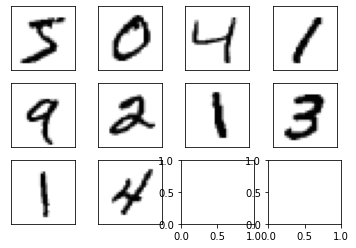

In [87]:
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, X_mnist[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(28,28))
plt.show()

*т.к. подсчет кластеров при помощи sklearn занимает много времени, я решил попробовать произвести кластеризацию при помощи алгоритма К-средних в PyTorch*

In [88]:
#start_cpu = time()
#cluster_mnist = clustering_agg.fit_predict(X_mnist)
#cpu_time = time() - start_cpu
#print('cpu time: {}'.format(cpu_time))

In [89]:
import torch
import umap
from kmeans_pytorch import kmeans
from time import time

In [90]:
# преобразование в тензор
X_torch = torch.from_numpy(X_mnist)

In [91]:
# кластеризация методом К-средних
cluster_ids_x, cluster_centers = kmeans(X=X_torch, num_clusters=10, distance='euclidean', device=torch.device('cuda:0'))

[running kmeans]: 0it [00:00, ?it/s]

running k-means on cuda:0..


[running kmeans]: 53it [03:50,  4.44s/it, center_shift=0.000000, iteration=53, tol=0.000100]      

In [92]:
v_score_mnist = v_measure_score(y_mnist, cluster_ids_x)
silh_score_mnist = silhouette_score(X_mnist, cluster_ids_x)

In [93]:
print('Значение силуэта равно {}, значение V-меры равно {}'.format(silh_score_mnist, v_score_mnist))

Значение силуэта равно 0.05858722728145597, значение V-меры равно 0.4920211728391844


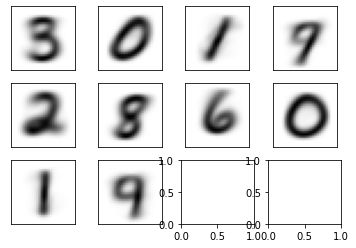

In [95]:
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, cluster_centers):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(28,28))
plt.show()

In [107]:
torch.cuda.empty_cache()

In [108]:
# попробуем снизить размерность датасета при помощи более быстрого UMAP 
#_sne = TSNE(n_components=3, init='pca', random_state=0)
embedding = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=0)

In [111]:
X_umap = embedding.fit_transform(X_mnist)

In [112]:
X_torch = torch.from_numpy(X_umap)

In [113]:
cluster_ids_x, cluster_centers = kmeans(X=X_torch, num_clusters=10, distance='euclidean', device=torch.device('cuda:0'))

[running kmeans]: 0it [00:00, ?it/s]

running k-means on cuda:0..


[running kmeans]: 12it [00:20, 13.22it/s, center_shift=0.000027, iteration=12, tol=0.000100]

In [114]:
v_score_umap = v_measure_score(y_mnist, cluster_ids_x)
silh_score_umap = silhouette_score(X_torch, cluster_ids_x)

In [116]:
print('Значение силуэта равно {}, значение V-меры равно {}'.format(silh_score_umap, v_score_umap))

Значение силуэта равно 0.6497141122817993, значение V-меры равно 0.8424633099941898


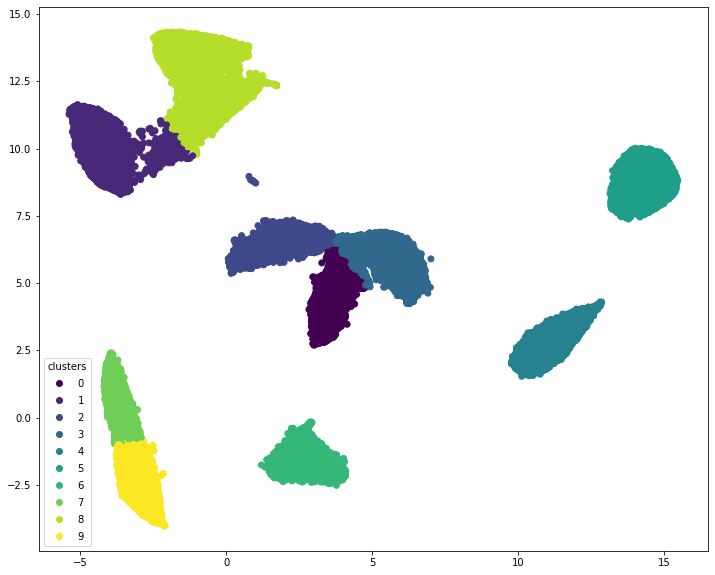

In [118]:
fig, ax = plt.subplots(figsize=(12,10))
cltrs = ax.scatter(x=X_torch[:, 0], y=X_torch[:, 1], c=cluster_ids_x, cmap='viridis')
ax.legend(*cltrs.legend_elements(), title='clusters')
plt.show()

In [119]:
# попробуем увеличить значение n_neighbors и заново прокластеризовать датасет
embedding.n_neighbors = 100

In [120]:
X_umap = embedding.fit_transform(X_mnist)

In [121]:
X_torch = torch.from_numpy(X_umap)
cluster_ids_x, cluster_centers = kmeans(X=X_torch, num_clusters=10, distance='euclidean', device=torch.device('cuda:0'))

[running kmeans]: 0it [00:00, ?it/s, center_shift=107.263466, iteration=1, tol=0.000100]

running k-means on cuda:0..


[running kmeans]: 14it [00:00, 32.20it/s, center_shift=0.000098, iteration=15, tol=0.000100]

In [124]:
v_score_umap_2 = v_measure_score(y_mnist, cluster_ids_x)
silh_score_umap_2 = silhouette_score(X_torch, cluster_ids_x)

In [125]:
print('После увеличения n_neighbors = {} значение силуэта равно {}, значение V-меры равно {}'.format(100, silh_score_umap_2, v_score_umap_2))

После увеличения n_neighbors = 100 значение силуэта равно 0.5346440076828003, значение V-меры равно 0.7935924748304634


*При первоначальных значениях алгоритма UMAP (**n_neighbors=30, min_dist=0.0, n_components=2, random_state=0**) было получено более высокое значение силуэта и V-меры.*

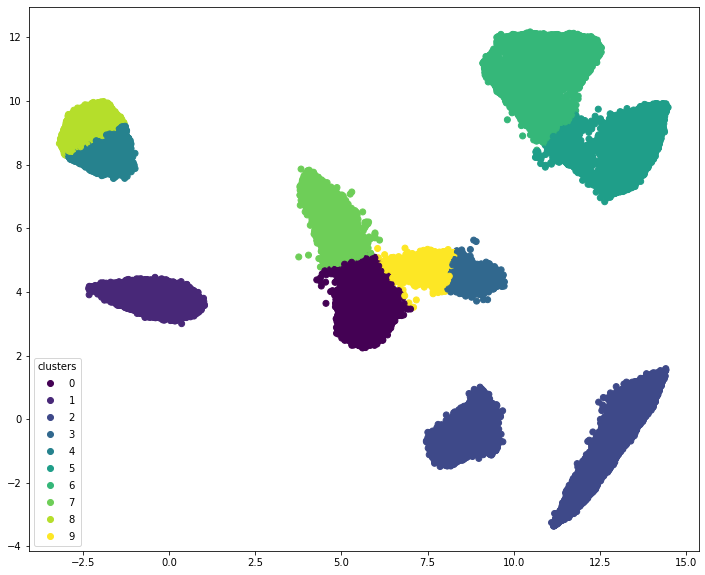

In [127]:
#на графике видно как изменились кластеры после увеличения значения n_neighbors
fig, ax = plt.subplots(figsize=(12,10))
cltrs = ax.scatter(x=X_torch[:, 0], y=X_torch[:, 1], c=cluster_ids_x, cmap='viridis')
ax.legend(*cltrs.legend_elements(), title='clusters')
plt.show()